In [1]:
# Packages
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans, MeanShift
from sklearn.decomposition import PCA

In [2]:
# Import Data
data = pd.read_csv("UsArrests.csv")

In [3]:
# Check Data
data.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


#### Observations:
- The data set is comprised of an index column "City" and four numerical features. All data features are continuous, and UrbanPop is a representation of percentage values.

In [4]:
# Check For Missing Data
data.isnull().sum()

City        0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

#### Observations:
- There are no null values in the data set; no imputation is required.
- For clarity's sake, I will rename the "City" column to "State" and, for future values, set the float values to only have two decimal values.

In [5]:
# Rename "City" Column to "State"
data.rename(columns={"City":"State"}, inplace=True)

In [6]:
# Set Float Precision
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

In [7]:
# Check Data Distribution
data.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00,50.00,50.00,50.00
mean,7.79,170.76,65.54,21.23
std,4.36,83.34,14.47,9.37
min,0.80,45.00,32.00,7.30
25%,4.08,109.00,54.50,15.07
50%,7.25,159.00,66.00,20.10
75%,11.25,249.00,77.75,26.18
max,17.40,337.00,91.00,46.00


#### Observations:
- Assault has much higher values than the other two crime stats, which makes sense given the range of incidents that could be construed as "assault" as well as the higher severity of the other two crimes.
- Urban Pop can be seen to scale from 1 to 100, which makes sense given that it is a percentage representation of urab population.
- Due to the slight variation in the scales of the data, standard scaling will likely be required

In [8]:
# Check DataFrame Format
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   State     50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


#### Observations:
- All dtypes of the data features are correct, with only "State" being non-numerical.
- As can be seen, this further confirms that there is no missing data.

/tmp/ipykernel_3032/3614327741.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_corr = data.corr()


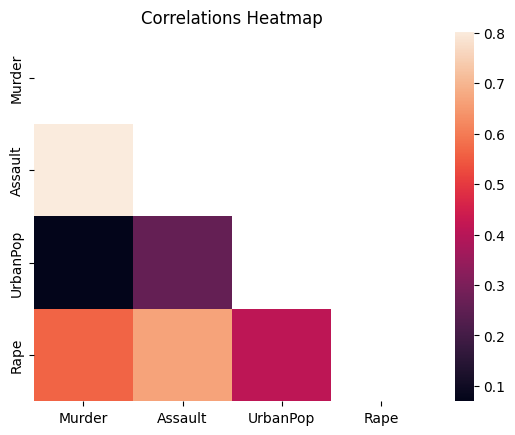

In [9]:
# Heatmap of Correlations
columns = list(data.columns)
data_corr = data.corr()
diag_mask = np.triu(data_corr)
sns.heatmap(data_corr, mask=diag_mask)
plt.title("Correlations Heatmap")
plt.show()

#### Observations:
- Assault has no correlation with murder. This makes sense as all murder is assault up until a point, so crimes reported as murder are unlikely to also be reported as an assault since the victim died.
- There are strong correlations between Urban Population percentage and all crime types.
- There is a slightly stronger correlation between Rape and Murder than between Rape and Assault.

In [10]:
# Fit PCA model
pca = PCA()
X = pca.fit_transform(data.drop("State", axis=1))
pca_data = pd.DataFrame(X)

In [11]:
# Biplot Function
def biplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    
    plt.scatter(xs * scalex,ys * scaley, s=5)
    
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0] * 0.5, coeff[i,1] * 0.5,color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 0.5, coeff[i,1] * 0.5, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 0.5, coeff[i,1] * 0.5, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    
    # Adapted from the example by Jun De Wu 
    # https://blog.damavis.com/en/principal-component-analysis-implementation-in-python/

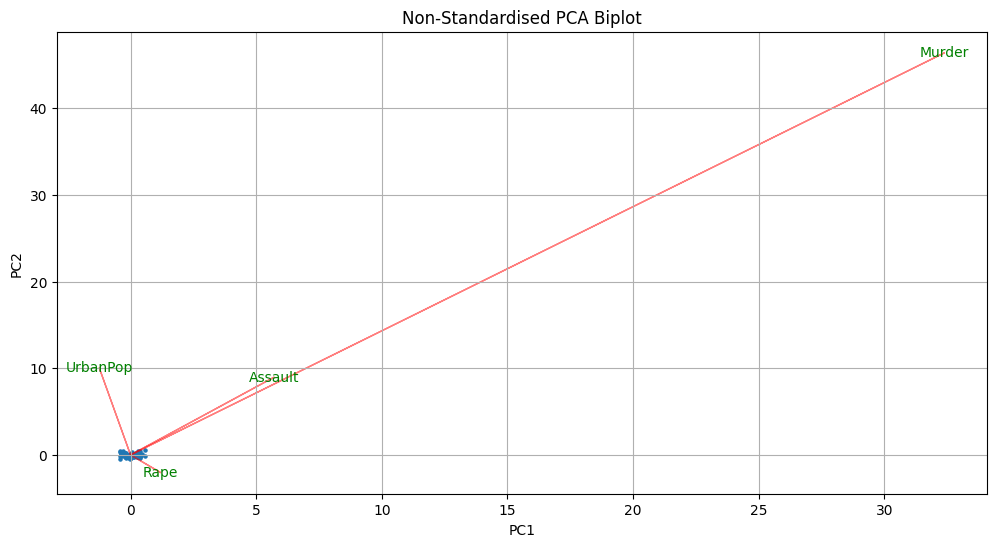

In [12]:
# PCA Biplot
plt.figure(figsize=(12, 6))
biplot(X,np.transpose(X),columns[1:5])
plt.title("Non-Standardised PCA Biplot")
plt.show()

#### Observations:
- This graph is unfortunately very unclear, as the tight grouping of the plot points is hard to understand  unscaled.
- Murder has an extremely high PCA score compared to other features.
- UrbanPop is the only feature with a negative PCA.

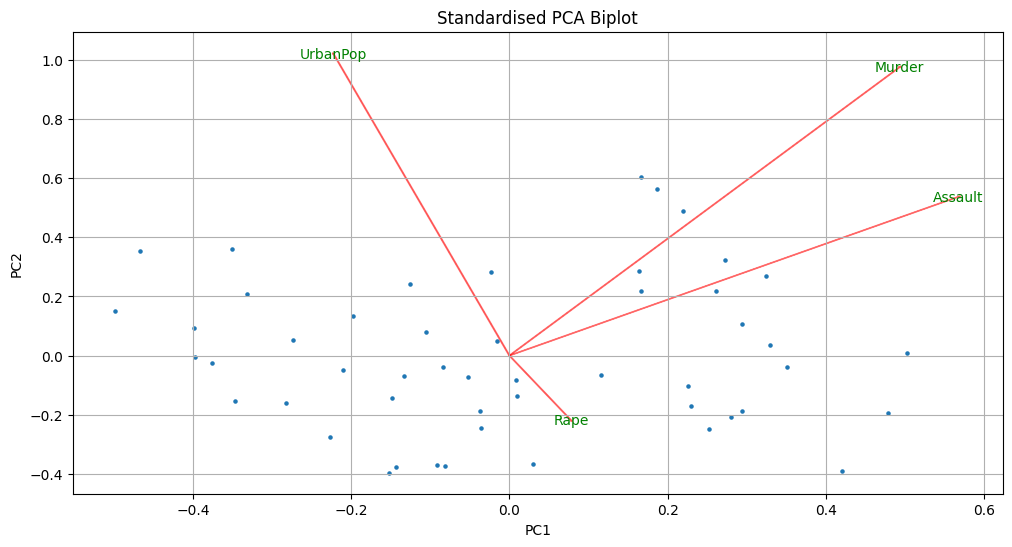

In [13]:
# Standardised PCA Biplot
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data.drop("State", axis=1))

pca_std = PCA()
X_std = pca_std.fit_transform(X_scaled)

plt.figure(figsize=(12, 6))
biplot(X_std,np.transpose(X_std),columns[1:5])
plt.title("Standardised PCA Biplot")
plt.show()

#### Observations:
- Data points have a much better distribution in this graph.
- There is a somewhat clear divide down the middle of the data around PC1 value 0.1. This may be a potential delimiter for clustering.
- UrbanPop is the only feature with a negative correlation.
- Of the three crime categories, rape has the lowest PCA score, with murder having the highest.

In [14]:
# Feature importance
feat_df = pd.DataFrame()
feat_df["Features"] = list(data.drop("State", axis=1).columns)
feat_df["PC1 Importance"] = abs(pca_std.components_[0])
feat_df["PC2 Importance"] = abs(pca_std.components_[1])
feat_df["PC3 Importance"] = abs(pca_std.components_[2])
feat_df["PC4 Importance"] = abs(pca_std.components_[3])
feat_df

,Features,PC1 Importance,PC2 Importance,PC3 Importance,PC4 Importance
0,Murder,0.54,0.42,0.34,0.65
1,Assault,0.58,0.19,0.27,0.74
2,UrbanPop,0.28,0.87,0.38,0.13
3,Rape,0.54,0.17,0.82,0.09


#### Observations:
- For the first PC, all features are roughly of the same importance besides UrbanPop, which is only about half as important as the others.
- For the second however, UrbanPop is extremely important, followed by Murder at 0.42 and Assault/Rape in the sub 0.2 range, meaning they are not important to any great extent.
- Component 3 sees Murder and UrbanPop have similar importance, with Rape being by far the most important overall and assault having the lowest importance by a small margin.
- Component 4 Places the vast majority of importance on Murder and Assault, with UrbanPop and Rape having minimal importance for this component

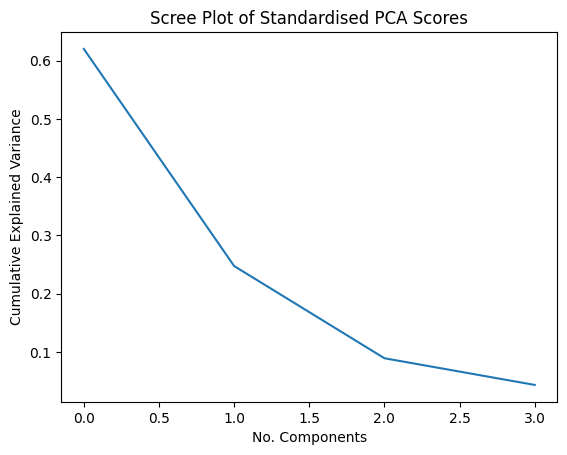

In [16]:
# Scree Plot for Standardised PCA Data
plt.plot(pca_std.explained_variance_ratio_)
plt.xlabel('No. Components')
plt.ylabel('Cumulative Explained Variance')
plt.title("Scree Plot of Standardised PCA Scores")
plt.show()

#### Observations:
- The first three principal components make up roughly 90% of the cumulative variance, therefore these are the only ones needed for component analysis. However, since there are only four in total, I will use all of them as this will not greatly affect efficiency.

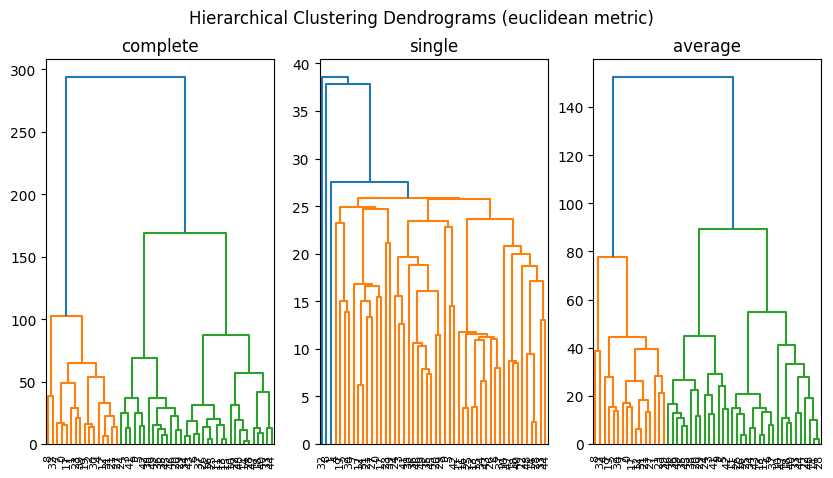

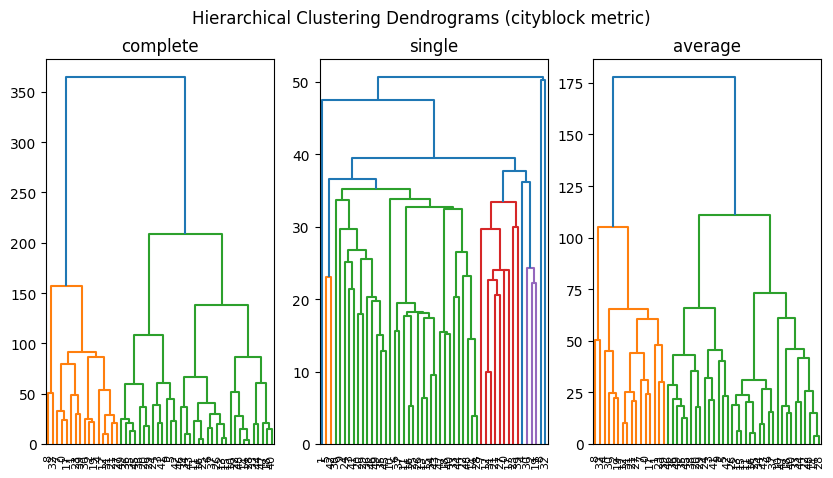

In [17]:
# Dendrogram Printouts
methods = ["single", "average", "complete"]
metrics = ["euclidean", "cityblock"]

for m in metrics:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[10,5])
    axes = [ax1,ax2,ax3]
    fig.suptitle('Hierarchical Clustering Dendrograms ({} metric)'.format(m))
    for i,axis in enumerate(axes):
        axis.set_title(methods[i-1])
        dendrogram(linkage(pca_data, method=methods[i-1], metric=m,), ax=axis)

#### Observations:
- Both "Average" and "Complete" seem to be suitable choices; average seems to be slightly more balanced however, so I will use this one for the final version. There doesn't seem to be much of a difference between these methods between metrics.
- The "single" method seems to have the most issue clustering the data, and has created confused clusters with both metrics.

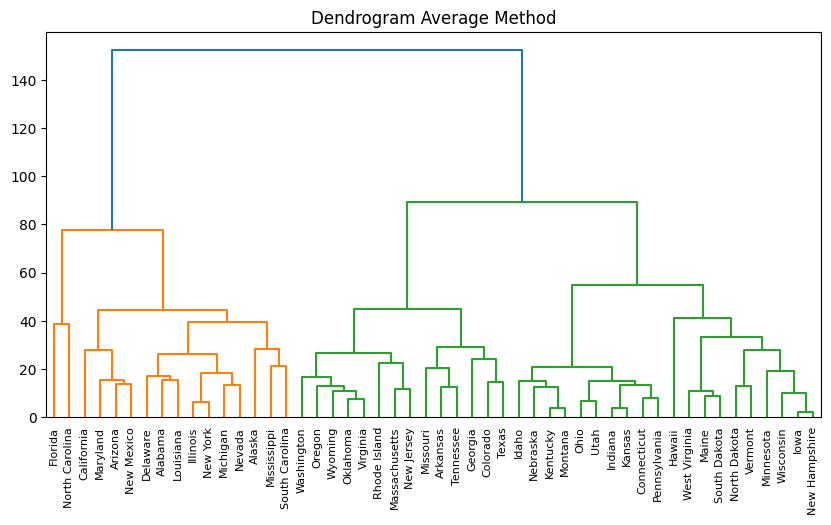

In [18]:
# Final Dendrogram
states=list(data["State"])

plt.figure(figsize=[10,5])
plt.title("Dendrogram Average Method")
dendrogram(linkage(pca_data, method="average"), labels=states)
plt.show()

#### Observations:
- There are two well balanced clusters in the set, with both containing a good number of data points.
- In the larger of the two clusters (green), there are two clear "sub-clusters", which could suggest that the data could successfully be split into three clusters.

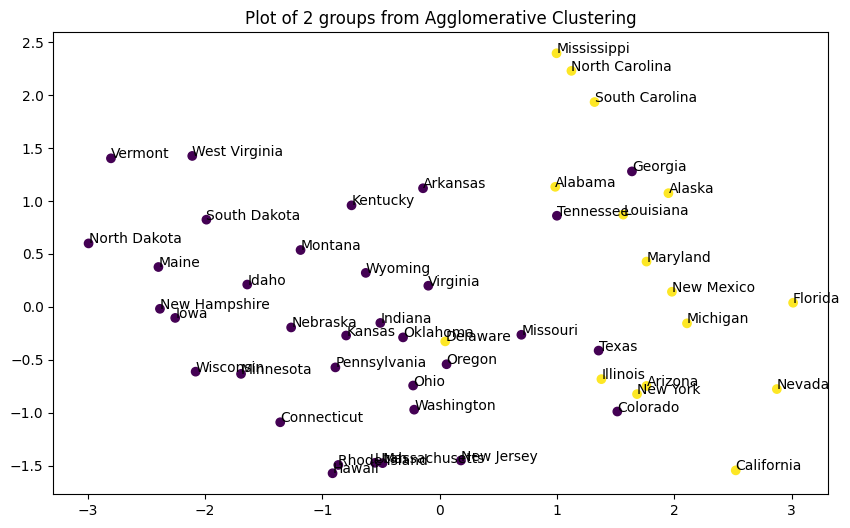

In [19]:
# Agglomerative Clustering Model
link = "complete"
metr = "euclidean"
agg_cluster = AgglomerativeClustering(n_clusters=2, affinity=metr, linkage=link)
agg_cluster.fit(X)
agg_cluster.fit_predict(pca_data)

# Plot clusters
def plot_clusters(cluster, title, k=""):
    plt.figure(figsize=[10,6])
    plt.scatter(X_std[:,0], X_std[:,1], c=cluster.labels_)
    for i in range(0,len(X_std[:,0])):
        txt = states[i]
        plt.annotate(txt, (X_std[i,0], X_std[i,1]))
    plt.title(f"Plot of {k} groups from {title}")
    plt.show()
    
plot_clusters(agg_cluster, "Agglomerative Clustering", 2)

#### Observations:
- The two groups are reasonably well distributed, forming two very clear groups in the scatter plot.
- There is some clear overlap between the two groups, with Delaware and Georgia being two particularly clear points that sit within the opposite cluster, and some confusion around Texas and Colorado.
- Just looking at this plot, there are no obvious further divisions in the data set that present themself, with the cluster divide taking place roughly around the point mentioned in the biplot observations.

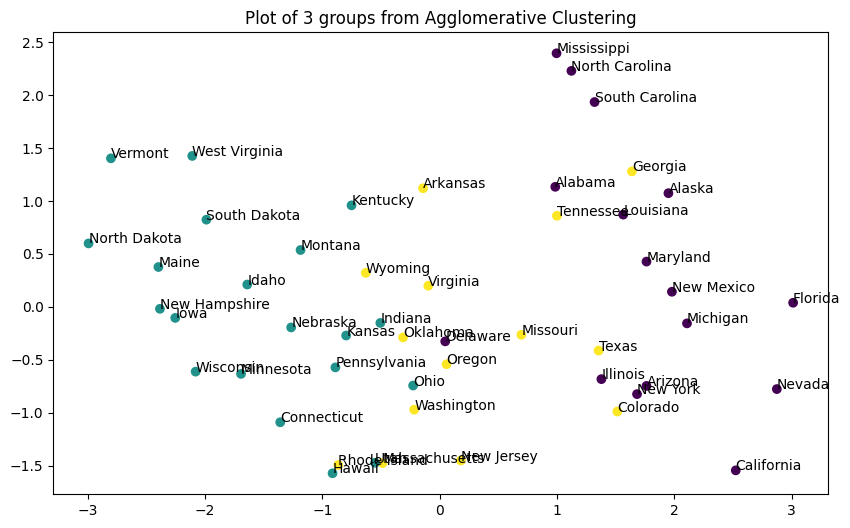

In [20]:
# Agglomerative Clustering Model (3 clusters)
link = "complete"
metr = "euclidean"
agg_cluster3 = AgglomerativeClustering(n_clusters=3, affinity=metr, linkage=link)
agg_cluster3.fit(X)
agg_cluster3.fit_predict(pca_data)

plot_clusters(agg_cluster3, "Agglomerative Clustering", 3)

#### Observations:
- Adding a third group to the Agglomerative clustering model takes most of its points from the left cluster of the two-group model, and forms a clear band down the middle of the plot. The clusters seem largely logical in makeup.
- There is some noticeable overlap between the new central cluster and the other two clusters, with Delaware and Georgia still looking out of place, and a slightly messy grouping of clusters towards the x-axis which form a somewhat confused border between clusters.

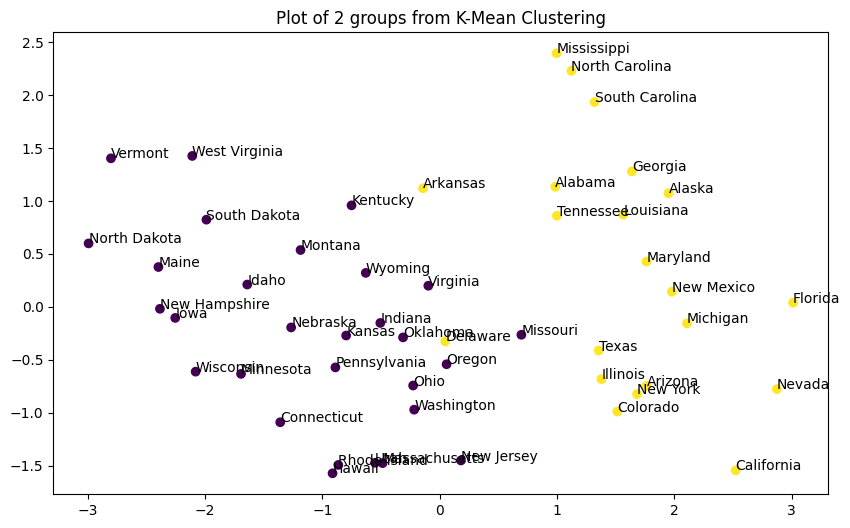

In [21]:
# K_Means Clustering Model (2 Groups)
kmean_cluster = KMeans(n_clusters=2)
kmean_cluster.fit(X)

plot_clusters(kmean_cluster, "K-Mean Clustering", 2)

#### Observations:
- The clusters formed in this model are largely similar to the Agglomerative model, with only minor changes in cluster composition.
- The overlap between the two clusters is minimal, with only Delaware now looking out of place within it's grouping. A much cleaner border could be drawn for this models' scatter plot than that of the Agglomerative model.

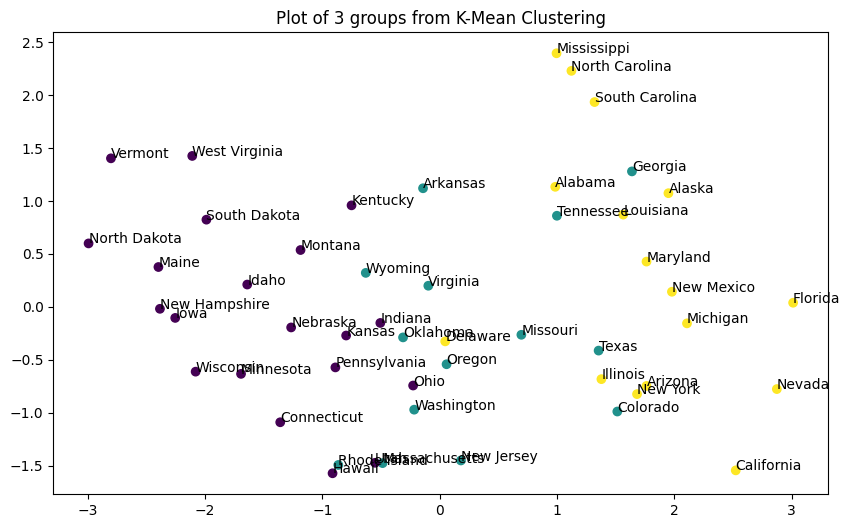

In [22]:
# K_Means Clustering Model (3 Groups)
kmean_cluster3 = KMeans(n_clusters=3)
kmean_cluster3.fit(X)

plot_clusters(kmean_cluster3, "K-Mean Clustering", 3)

#### Observations:
- Despite the differences between the Agglomerative and KMean models with two clusters, the models produce identical plots when upped to 3 clusters apiece. Interestingly, this makes the K-Mean model replicate the splitting of Georgia and Tennessee from their immediate neighbours as in the original 2 cluster Agglomerative model.
- As mentioned beneath the dendrogram prior, there did seem to be a clear potential for a third cluster within the two clusters of the original model. This may explain the even distribution of the three cluster scatter plot.

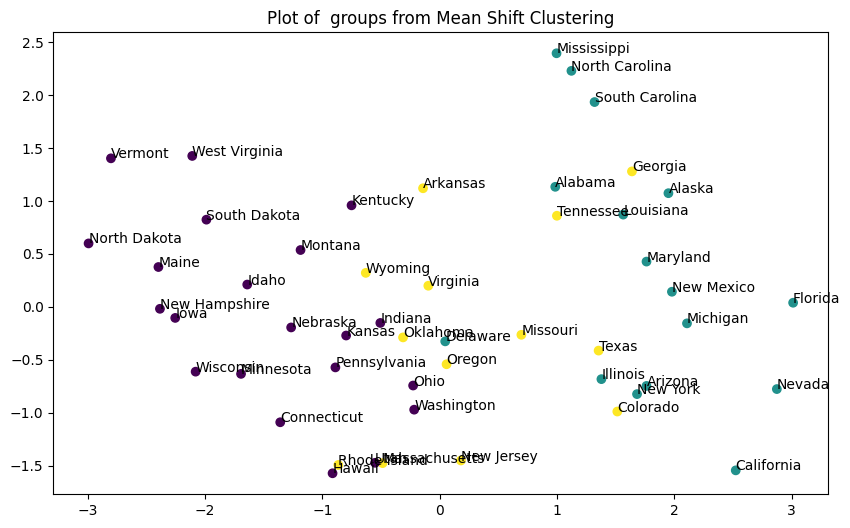

In [23]:
# MeanShift Clustering
mshift_cluster = MeanShift()
mshift_cluster.fit(X)

plot_clusters(mshift_cluster, "Mean Shift Clustering")

#### Observations:
- The Mean Shift model seems to create extremely similar clusters to the other two models, and settles on three clusters as being the most suitable number. 
- The only difference between this model and the other two models - when the number of clusters is 3 - is that Washington is made part of the left cluster rather than the central cluster. To my eye, this is actually slightly more logical, and forms a slightly cleaner border between clusters in that area.

In [24]:
# Histogram Printouts Function
def print_hists(model, suptitle):
    temp_data = data.copy()
    temp_data["cluster"]=model.labels_
    clusters = list(temp_data["cluster"].unique())

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 5))
    axes = [ax1, ax2, ax3, ax4]
    fields = list(data.drop("State", axis=1).columns)
    fig.suptitle(suptitle)

    for i, axis in enumerate(axes):
        for cluster in clusters:
            group = temp_data[temp_data["cluster"] == cluster]
            sns.histplot(data=group, x=fields[i-1], ax=axis)

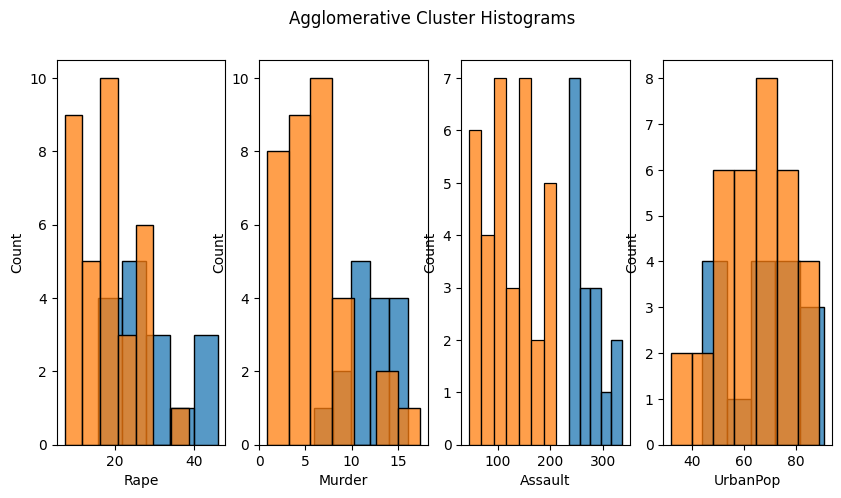

In [25]:
print_hists(agg_cluster, "Agglomerative Cluster Histograms")

#### Observations:
- Of the four features for this model, Murder and Assault seem to offer the clearest separation between groups. Assault in particular has no overlap whatsoever between the clusters, suggesting that Assault was a key feature in separating the clusters for the model.
- Rape does see some evidence of separation between the clusters, but not as clearly as Murder or Assault.
- UrbanPop sees no separation of the two clusters at all. This lines up with previous observations made about correlations between UrbanPop and the other features which were all extremely high and not very useful for clustering.

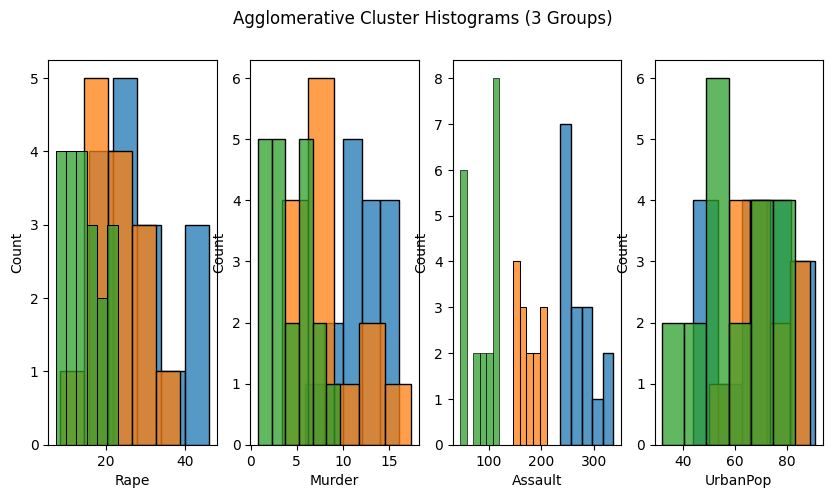

In [26]:
print_hists(agg_cluster3, "Agglomerative Cluster Histograms (3 Groups)")

#### Observations:
- In this model the clusters for the Murder feature have become much more confused by the addition of an additional cluster. The Rape Feature seems to be somewhat more logical, however there is a great degree of overlap between clusters.
- As before, the Assault feature sees perfectly separated clusters, with UrbanPop being extremely confused and not separated at all.

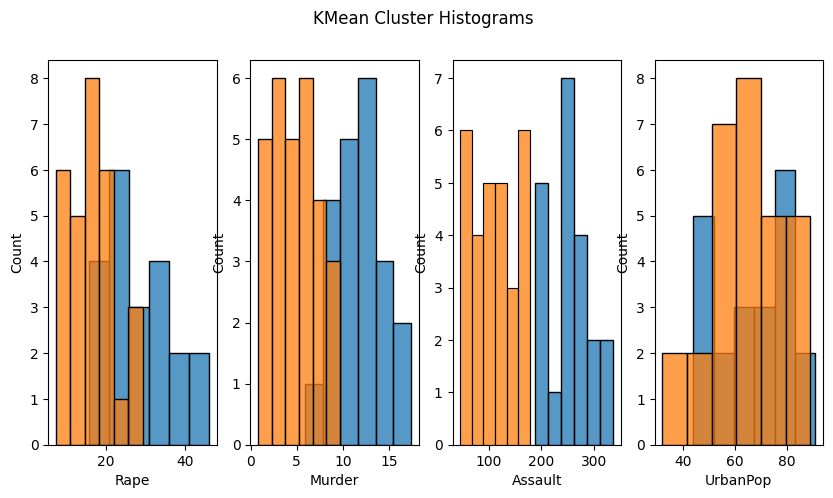

In [27]:
print_hists(kmean_cluster, "KMean Cluster Histograms")

#### Observations:
- The overlap between clusters is much improved across the board for the K-Means model (barring UrbanPop) with Rape, Murder and Assault all having clear groups with minimal (or zero) overlap.
- The clustering for the Murder feature is the most improved to my eye, with a much cleaner border between the two clusters and no outliers present. The Rape feature grouping is similarly improved.

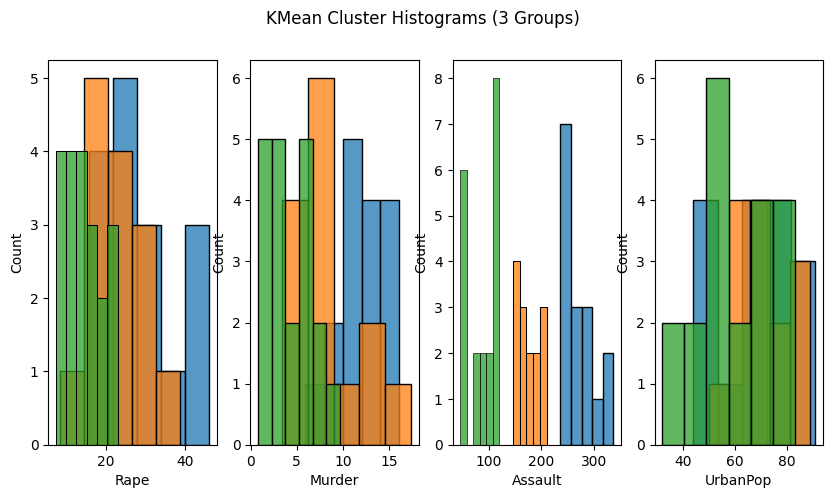

In [28]:
print_hists(kmean_cluster3, "KMean Cluster Histograms (3 Groups)")

#### Observations:
- As with the three-cluster agglomerative model, the grouping of Murder for this model seems more confused than the original two cluster model (as would be expected given that the models create identical clusters).
- Since these clusters are identical to the agglomerative three cluster model, there is not much else to observe, aside from the fact that this may suggest that the three-cluster models makes for better representation of groupings within the data, given that both models converged on the same patterns.

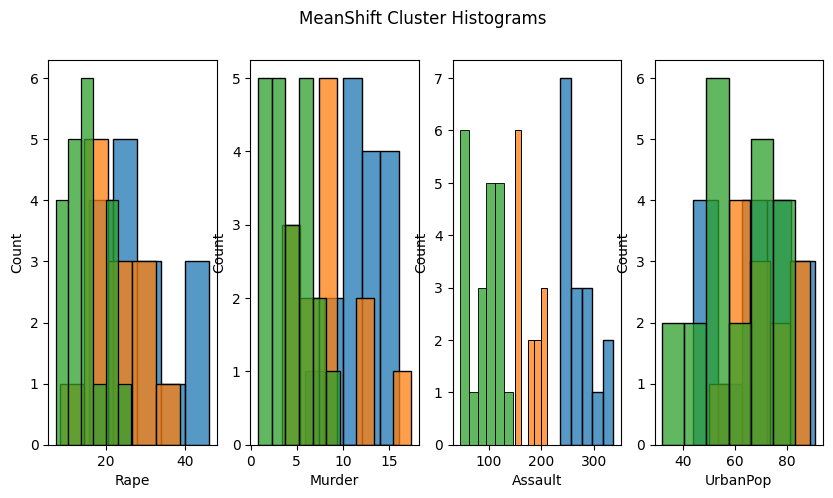

In [29]:
print_hists(mshift_cluster, "MeanShift Cluster Histograms")

#### Observations:
- As would be expected given the extremely similar scatterplot output, the Mean Shift model histograms are almost identical to the KMean and Agglomerative model histograms seen above. As such, there is not much to comment on here, besides that this reaffirms the suitability of a three-cluster model for analysing this data.

GitHub Link: https://github.com/ArchieMacdonald1996/Archies-Box.git